# 5 Sınıflı Afet Hasarı Görüntü Sınıflandırma - Conv2d Tabanlı CNN

Bu notebook, Kaggle'dan afet hasarı görüntü veri setini kullanarak PyTorch ile Conv2d tabanlı CNN modeli eğitmeyi amaçlamaktadır.

## Proje Özeti

- **Veri Seti**: Kaggle - Disaster Damage 5-Class Dataset (kagglehub ile indirilecek)
- **Model**: PyTorch CNN (Conv2d tabanlı)
- **Sınıflar**: 5 sınıf afet hasarı kategorisi
- **Görüntü Boyutu**: 224x224 piksel

## Model Özellikleri

- **Mimari**: 3 Conv Bloğu (Conv2d, BatchNorm, ReLU, MaxPooling) + FC (Dropout 0.6)
- **Optimizer**: Adam (lr=1e-4, weight_decay=1e-4)
- **Loss**: CrossEntropyLoss
- **Scheduler**: ReduceLROnPlateau (patience=7)
- **Regularization**: Dropout (0.6), Early Stopping, Weight Decay
- **Data Augmentation**: Güçlendirilmiş (Rotation, Zoom, Shift, Horizontal Flip, ColorJitter - sadece eğitim için)
- **Hedefler**: Yüksek Accuracy, Düşük Loss

## İçindekiler

1. Kütüphaneleri Yükleme
2. Veri Setini İndirme (Kagglehub)
3. Veri Setini Hazırlama
   - 3.1 Dataset Sınıfı
   - 3.2 Data Augmentation ve Transformlar
   - 3.3 Dataset ve DataLoader Oluşturma
4. CNN Model Tanımı
5. Yardımcı Fonksiyonlar
6. Eğitim ve Doğrulama Fonksiyonları
7. Model Eğitimi
8. Sonuçları Görselleştirme
9. Model Testi
10. Örnek Tahminler



## 1. Kütüphaneleri Yükleme

Gerekli kütüphaneler import ediliyor:
- **PyTorch**: Model mimarisi ve eğitim için
- **PIL**: Görüntü işleme (truncated image desteği aktif)
- **NumPy/Pandas**: Veri manipülasyonu
- **Matplotlib/Seaborn**: Görselleştirme
- **Scikit-learn**: Metrik hesaplama ve veri split
- **Kagglehub**: Veri seti indirme



In [11]:
# Temel kütüphaneler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image, ImageFile

# Truncated image'ları yüklemeye izin ver
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Veri işleme
import numpy as np
import pandas as pd
from pathlib import Path
import shutil
import os
import random
import time

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

# Metrikler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Progress bar
from tqdm import tqdm

# Kaggle veri indirme
import kagglehub

# Cihaz ayarları
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Kullanılan cihaz: {device}")

print("✅ Tüm kütüphaneler yüklendi!")



Kullanılan cihaz: cpu
✅ Tüm kütüphaneler yüklendi!


## 2. Veri Setini İndirme (Kagglehub)

Kaggle'dan `sarthaktandulje/disaster-damage-5class` veri seti indiriliyor.

**İşlemler:**
- Kagglehub ile otomatik indirme
- Dataset yapısı otomatik tespit (Training/Testing veya direkt sınıf klasörleri)
- Sınıf isimleri otomatik belirleniyor
- Train ve test klasör yolları belirleniyor



In [12]:
print("⏳ Veri seti indiriliyor (kagglehub ile)...")

# Kagglehub ile veri setini indir
cache_path = kagglehub.dataset_download("sarthaktandulje/disaster-damage-5class")

print(f"✅ İndirme tamamlandı. Konum: {cache_path}")
print(f"📂 Path to dataset files: {cache_path}")

# Dataset yapısını bul - farklı olası yapıları kontrol et
dataset_base = None
possible_paths = [
    os.path.join(cache_path, "dataset"),
    os.path.join(cache_path, "disaster-damage-5class"),
    os.path.join(cache_path, "disaster_dataset", "disaster_dataset"),  # İç içe klasör yapısı
    os.path.join(cache_path, "disaster_dataset"),
    cache_path
]

# Önce Training/Testing klasörlerini ara
for p in possible_paths:
    train_dir = os.path.join(p, "Training")
    if not os.path.exists(train_dir):
        train_dir = os.path.join(p, "train")
    if not os.path.exists(train_dir):
        train_dir = os.path.join(p, "Train")
    if os.path.exists(train_dir):
        dataset_base = p
        TRAIN_DIR = train_dir
        # Test klasörünü bul
        test_dir = os.path.join(p, "Testing")
        if not os.path.exists(test_dir):
            test_dir = os.path.join(p, "test")
        if not os.path.exists(test_dir):
            test_dir = os.path.join(p, "Test")
        TEST_DIR = test_dir if os.path.exists(test_dir) else None
        break

# Eğer Training/Testing yoksa, direkt sınıf klasörlerini ara
if dataset_base is None:
    for p in possible_paths:
        # Sınıf klasörlerini kontrol et (fire, flood, landslide, normal, smoke)
        if os.path.exists(p):
            subdirs = [d for d in os.listdir(p) 
                      if os.path.isdir(os.path.join(p, d)) and not d.startswith('.')]
            # Eğer sınıf isimleri varsa (fire, flood, landslide, normal, smoke gibi)
            if len(subdirs) >= 3:  # En az 3 sınıf olmalı
                # İçinde görüntü dosyası olan klasörleri kontrol et
                has_images = False
                for subdir in subdirs:
                    subdir_path = os.path.join(p, subdir)
                    files = [f for f in os.listdir(subdir_path) 
                            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
                    if len(files) > 0:
                        has_images = True
                        break
                if has_images:
                    dataset_base = p
                    TRAIN_DIR = p  # Tüm veri burada, train/val/test olarak ayıracağız
                    TEST_DIR = None
                    break

# Eğer hala bulunamadıysa, cache_path'i kullan
if dataset_base is None:
    dataset_base = cache_path
    TRAIN_DIR = cache_path
    TEST_DIR = None

print(f"✅ Dataset yolu bulundu: {dataset_base}")
print(f"📂 Veri klasörü: {TRAIN_DIR}")
if TEST_DIR:
    print(f"📂 Test klasörü: {TEST_DIR} (Ayrı test seti mevcut)")
else:
    print(f"📂 Test klasörü: Yok (Tüm veri train/val/test olarak ayrılacak)")

# Sınıf isimlerini otomatik bul
CLASS_NAMES = []
if os.path.exists(TRAIN_DIR):
    # Önce direkt klasörde sınıfları ara
    dirs = [d for d in os.listdir(TRAIN_DIR) 
            if os.path.isdir(os.path.join(TRAIN_DIR, d)) and not d.startswith('.')]
    
    # Eğer içinde görüntü dosyası varsa sınıf olarak kabul et
    for d in dirs:
        dir_path = os.path.join(TRAIN_DIR, d)
        files = [f for f in os.listdir(dir_path) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        if len(files) > 0:
            CLASS_NAMES.append(d)
    
    CLASS_NAMES.sort()
    NUM_CLASSES = len(CLASS_NAMES)
    
    if NUM_CLASSES > 0:
        print(f"✅ Sınıflar otomatik tespit edildi: {CLASS_NAMES}")
        print(f"📊 Toplam sınıf sayısı: {NUM_CLASSES}")
    else:
        print("⚠️ Sınıf klasörleri bulunamadı, manuel belirlenmeli")
        # Varsayılan sınıflar
        CLASS_NAMES = ['fire', 'flood', 'landslide', 'normal', 'smoke']
        NUM_CLASSES = 5
        print(f"⚠️ Varsayılan sınıflar kullanılıyor: {CLASS_NAMES}")
else:
    print("⚠️ Dataset klasörü bulunamadı!")
    CLASS_NAMES = ['fire', 'flood', 'landslide', 'normal', 'smoke']
    NUM_CLASSES = 5
    print(f"⚠️ Varsayılan sınıflar kullanılıyor: {CLASS_NAMES}")



⏳ Veri seti indiriliyor (kagglehub ile)...
✅ İndirme tamamlandı. Konum: C:\Users\ahmet\.cache\kagglehub\datasets\sarthaktandulje\disaster-damage-5class\versions\2
📂 Path to dataset files: C:\Users\ahmet\.cache\kagglehub\datasets\sarthaktandulje\disaster-damage-5class\versions\2
✅ Dataset yolu bulundu: C:\Users\ahmet\.cache\kagglehub\datasets\sarthaktandulje\disaster-damage-5class\versions\2\disaster_dataset\disaster_dataset
📂 Veri klasörü: C:\Users\ahmet\.cache\kagglehub\datasets\sarthaktandulje\disaster-damage-5class\versions\2\disaster_dataset\disaster_dataset
📂 Test klasörü: Yok (Tüm veri train/val/test olarak ayrılacak)
✅ Sınıflar otomatik tespit edildi: ['fire', 'flood', 'landslide', 'normal', 'smoke']
📊 Toplam sınıf sayısı: 5


## 3. Veri Setini Hazırlama

Veri setini PyTorch ile kullanılabilir hale getirmek için hazırlık yapılıyor.



### 3.1 Dataset Sınıfı

PyTorch `Dataset` sınıfından türetilen özel `DisasterDataset` sınıfı tanımlanıyor.

**Özellikler:**
- Görüntüleri yükler ve RGB formatına dönüştürür
- Truncated (bozuk) görüntü hatalarını yakalar ve siyah görüntü döndürür
- Transform işlemlerini uygular
- Etiketleri döndürür



In [13]:
class DisasterDataset(Dataset):
    """Afet hasarı görüntü veri seti sınıfı"""
    
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Görüntüyü yükle - truncated image hatalarını handle et
        try:
            # ImageFile.LOAD_TRUNCATED_IMAGES zaten import edildi ve True yapıldı
            image = Image.open(img_path).convert('RGB')
            # Görüntüyü yükle ve boyutunu kontrol et
            if image.size[0] == 0 or image.size[1] == 0:
                raise ValueError("Görüntü boyutu geçersiz")
        except Exception as e:
            # Hata durumunda siyah görüntü döndür (sessizce, sadece ilk birkaç hatayı göster)
            if not hasattr(self, '_error_count'):
                self._error_count = 0
            if self._error_count < 5:  # İlk 5 hatayı göster
                print(f"⚠️ Hata: {os.path.basename(img_path)} yüklenemedi: {str(e)[:60]}")
                self._error_count += 1
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        # Dönüşümleri uygula
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("✅ Dataset sınıfı tanımlandı! (Truncated image desteği eklendi)")



✅ Dataset sınıfı tanımlandı! (Truncated image desteği eklendi)


### 3.2 Data Augmentation ve Transformlar

Hiperparametreler ve transformlar tanımlanıyor.

**Hiperparametreler:**
- `IMG_SIZE`: 224x224 piksel
- `BATCH_SIZE`: 32 (başlangıç, dataset boyutuna göre otomatik ayarlanacak)
- `EPOCHS`: 50 (maksimum, dataset boyutuna göre otomatik ayarlanacak)
- `LEARNING_RATE`: 1e-4

**Training Transform:**
- Resize (274x274) → RandomCrop (224x224)
- RandomRotation (±35°)
- RandomAffine (kaydırma ve zoom)
- RandomHorizontalFlip
- ColorJitter (parlaklık, kontrast, doygunluk, renk tonu)
- Normalize (ImageNet mean/std)

**Validation Transform:**
- Resize (224x224)
- Normalize (ImageNet mean/std)



In [14]:
# Hiperparametreler (Başlangıç değerleri - dataset yüklendikten sonra otomatik ayarlanacak)
IMG_SIZE = 224
BATCH_SIZE = 32  # Başlangıç değeri, dataset boyutuna göre ayarlanacak
EPOCHS = 50  # Maksimum 50 epoch (dataset boyutuna göre ayarlanacak)
LEARNING_RATE = 1e-4  # Aşırı düşük değil, çok yavaş warmup yok

# Training için güçlendirilmiş data augmentation (yüksek accuracy, düşük loss için)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE + 50, IMG_SIZE + 50)),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomRotation(degrees=35),  # Rastgele döndürme
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.85, 1.15)),  # Kaydırma ve yakınlaştırma
    transforms.RandomHorizontalFlip(p=0.5),  # Yatay çevirme
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Renk değişiklikleri
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation için sadece normalize
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✅ Data Augmentation (Güçlendirilmiş):")
print("  Training: Resize, RandomCrop, RandomRotation(35°), RandomAffine(shift+zoom), RandomHorizontalFlip, ColorJitter")
print("  Validation: Resize, Normalize")



✅ Data Augmentation (Güçlendirilmiş):
  Training: Resize, RandomCrop, RandomRotation(35°), RandomAffine(shift+zoom), RandomHorizontalFlip, ColorJitter
  Validation: Resize, Normalize


### 3.3 Dataset ve DataLoader Oluşturma

Veri seti train/val/test olarak bölünüyor ve PyTorch DataLoader'lar oluşturuluyor.

**Split Stratejisi:**
- Ayrı test klasörü varsa: Train/Val (80/20) + Test (ayrı)
- Test klasörü yoksa: Train/Val/Test (70/15/15)

**Otomatik Hiperparametre Ayarlama:**
- **Batch Size**: Dataset boyutuna göre (16/32/64)
- **Epochs**: Dataset boyutuna göre (30/50 maksimum)

**Çıktılar:**
- Train/Val/Test dataset ve DataLoader nesneleri
- Sınıf başına görüntü sayıları



In [15]:
# Tüm görüntü yollarını ve etiketlerini topla
all_images = []
all_labels = []
for class_name in CLASS_NAMES:
    class_dir = os.path.join(TRAIN_DIR, class_name)
    if os.path.exists(class_dir):
        class_idx = CLASS_NAMES.index(class_name)
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                all_images.append(os.path.join(class_dir, img_name))
                all_labels.append(class_idx)

print(f"📊 Toplam görüntü sayısı: {len(all_images)}")

# Eğer TEST_DIR varsa, test setini ayrı topla
# Yoksa tüm veriyi train/val/test olarak ayır
if TEST_DIR and os.path.exists(TEST_DIR):
    # Test seti ayrı klasörde
    test_images = []
    test_labels = []
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(TEST_DIR, class_name)
        if os.path.exists(class_dir):
            class_idx = CLASS_NAMES.index(class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    test_images.append(os.path.join(class_dir, img_name))
                    test_labels.append(class_idx)
    
    # Kalan veriyi train/val olarak ayır (80/20)
    train_images, val_images, train_labels, val_labels = train_test_split(
        all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
    )
    print(f"📊 Test seti ayrı klasörden yüklendi: {len(test_images)} görüntü")
else:
    # Tüm veriyi train/val/test olarak ayır (70/15/15)
    # Önce train ve geçici (val+test) olarak ayır (70/30)
    train_images, temp_images, train_labels, temp_labels = train_test_split(
        all_images, all_labels, test_size=0.3, random_state=42, stratify=all_labels
    )
    # Sonra val/test olarak ayır (50/50) - bu 30'un yarısı = 15% val, 15% test
    val_images, test_images, val_labels, test_labels = train_test_split(
        temp_images, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )
    print(f"📊 Veri train/val/test olarak ayrıldı (70/15/15)")

# Dataset boyutuna göre hiperparametreleri otomatik ayarla
train_size = len(train_images)
val_size = len(val_images)
test_size = len(test_images)

# Batch size ayarlama (dataset boyutuna göre)
if train_size < 500:
    BATCH_SIZE = 16
    print("⚠️  Küçük dataset tespit edildi, Batch Size: 16 olarak ayarlandı")
elif train_size < 2000:
    BATCH_SIZE = 32
    print("✅ Orta dataset tespit edildi, Batch Size: 32 olarak ayarlandı")
else:
    BATCH_SIZE = 64
    print("✅ Büyük dataset tespit edildi, Batch Size: 64 olarak ayarlandı")

# Epoch sayısını dataset boyutuna göre ayarla (maksimum 50)
if train_size < 500:
    EPOCHS = 30
    print("⚠️  Küçük dataset için Epoch: 30 olarak ayarlandı")
elif train_size < 2000:
    EPOCHS = 50
    print("✅ Orta dataset için Epoch: 50 olarak ayarlandı")
else:
    EPOCHS = 50  # Maksimum 50 epoch
    print("✅ Büyük dataset için Epoch: 50 olarak ayarlandı (maksimum)")

# Dataset ve DataLoader oluştur
train_dataset = DisasterDataset(train_images, train_labels, transform=train_transform)
val_dataset = DisasterDataset(val_images, val_labels, transform=val_transform)
test_dataset = DisasterDataset(test_images, test_labels, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Sınıf başına görüntü sayısını hesapla
class_counts = {}
for class_name in CLASS_NAMES:
    train_count = sum(1 for label in train_labels if CLASS_NAMES[label] == class_name)
    val_count = sum(1 for label in val_labels if CLASS_NAMES[label] == class_name)
    test_count = sum(1 for label in test_labels if CLASS_NAMES[label] == class_name)
    class_counts[class_name] = {'train': train_count, 'val': val_count, 'test': test_count}

print(f"\n✅ Dataset Yüklendi:")
print(f"  - Training: {len(train_dataset)} görüntü")
print(f"  - Validation: {len(val_dataset)} görüntü")
print(f"  - Test: {len(test_dataset)} görüntü")
print(f"  - Toplam: {len(train_dataset) + len(val_dataset) + len(test_dataset)} görüntü")
print(f"\n📊 Sınıf Başına Görüntü Sayısı:")
for class_name in CLASS_NAMES:
    counts = class_counts[class_name]
    print(f"  - {class_name}: Train={counts['train']}, Val={counts['val']}, Test={counts['test']}")
print(f"\n⚙️  Eğitim Parametreleri:")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Steps per Epoch: {len(train_loader)}")
print(f"  - Toplam Eğitim Adımı: {len(train_loader) * EPOCHS}")



📊 Toplam görüntü sayısı: 8081
📊 Veri train/val/test olarak ayrıldı (70/15/15)
✅ Büyük dataset tespit edildi, Batch Size: 64 olarak ayarlandı
✅ Büyük dataset için Epoch: 50 olarak ayarlandı (maksimum)

✅ Dataset Yüklendi:
  - Training: 5656 görüntü
  - Validation: 1212 görüntü
  - Test: 1213 görüntü
  - Toplam: 8081 görüntü

📊 Sınıf Başına Görüntü Sayısı:
  - fire: Train=1776, Val=380, Test=381
  - flood: Train=1894, Val=406, Test=406
  - landslide: Train=217, Val=46, Test=47
  - normal: Train=1558, Val=334, Test=334
  - smoke: Train=211, Val=46, Test=45

⚙️  Eğitim Parametreleri:
  - Batch Size: 64
  - Epochs: 50
  - Learning Rate: 0.0001
  - Steps per Epoch: 89
  - Toplam Eğitim Adımı: 4450


In [16]:
class DisasterCNN(nn.Module):
    """
    5 sınıflı afet hasarı görüntülerini sınıflandırmak için CNN modeli
    
    Mimari:
    - 3 Convolutional katman
    - Batch Normalization
    - Max Pooling
    - Dropout
    - Fully Connected katmanlar
    """
    
    def __init__(self, num_classes=5):
        super(DisasterCNN, self).__init__()
        
        # İlk Convolutional Blok
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # İkinci Convolutional Blok
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Üçüncü Convolutional Blok
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Global Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully Connected Katmanlar (Dropout oranları optimize edildi)
        self.fc1 = nn.Linear(256, 128)
        self.dropout1 = nn.Dropout(0.6)  # Artırıldı - training sırasında daha fazla regularization
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.6)  # Artırıldı - training sırasında daha fazla regularization
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # İlk blok
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        # İkinci blok
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        # Üçüncü blok
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        # Global Average Pooling
        x = self.avgpool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully Connected
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x


def get_model(num_classes=5, device='cuda'):
    """
    Model oluşturur ve belirtilen cihaza yükler
    
    Args:
        num_classes: Sınıf sayısı (5: afet hasarı kategorileri)
        device: 'cuda' veya 'cpu'
    
    Returns:
        Model
    """
    model = DisasterCNN(num_classes=num_classes)
    model = model.to(device)
    return model

# Model özeti dosyasına yaz
def get_model_summary(model, num_classes, class_names, img_size, batch_size, learning_rate, epochs):
    """Model özetini string olarak döndürür"""
    summary = []
    summary.append("="*60)
    summary.append("MODEL ÖZETİ")
    summary.append("="*60)
    summary.append("")
    summary.append(f"Model: DisasterCNN")
    summary.append(f"Sınıf Sayısı: {num_classes}")
    summary.append(f"Sınıflar: {class_names}")
    summary.append("")
    summary.append("="*60)
    summary.append("MİMARİ")
    summary.append("="*60)
    summary.append("")
    summary.append("Conv Block 1: Conv2d(3,64) + BatchNorm + ReLU + MaxPool2d")
    summary.append("Conv Block 2: Conv2d(64,128) + BatchNorm + ReLU + MaxPool2d")
    summary.append("Conv Block 3: Conv2d(128,256) + BatchNorm + ReLU + MaxPool2d")
    summary.append("Global Average Pooling: AdaptiveAvgPool2d((1,1))")
    summary.append("FC Layers: Linear(256,128) + ReLU + Dropout(0.6)")
    summary.append("           Linear(128,64) + ReLU + Dropout(0.6)")
    summary.append("           Linear(64,{})".format(num_classes))
    summary.append("")
    summary.append("="*60)
    summary.append("PARAMETRELER")
    summary.append("="*60)
    summary.append("")
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    summary.append(f"Toplam Parametre: {total:,}")
    summary.append(f"Eğitilebilir Parametre: {trainable:,}")
    summary.append("")
    summary.append("="*60)
    summary.append("HİPERPARAMETRELER")
    summary.append("="*60)
    summary.append("")
    summary.append(f"Görüntü Boyutu: {img_size}x{img_size}")
    summary.append(f"Batch Size: {batch_size}")
    summary.append(f"Learning Rate: {learning_rate}")
    summary.append(f"Epochs: {epochs}")
    summary.append(f"Optimizer: Adam (weight_decay=1e-4)")
    summary.append(f"Loss: CrossEntropyLoss")
    summary.append(f"Scheduler: ReduceLROnPlateau (patience=7)")
    summary.append(f"Dropout: 0.6")
    summary.append(f"Data Augmentation: Güçlendirilmiş (ColorJitter, artırılmış rotation/affine)")
    summary.append("")
    return "\n".join(summary)

print("✅ Model tanımı hazır!")



✅ Model tanımı hazır!


## 6. Eğitim ve Doğrulama Fonksiyonları

Model eğitimi ve doğrulama için ana fonksiyonlar tanımlanıyor.

**Fonksiyonlar:**
- `train_epoch()`: Bir epoch boyunca model eğitimi
  - Forward ve backward pass
  - Loss ve accuracy hesaplama
  - Progress bar ile ilerleme gösterimi
  
- `validate()`: Model doğrulama
  - Test/validation seti üzerinde değerlendirme
  - Loss ve accuracy hesaplama
  - Tahminleri döndürme


In [17]:
def get_device():
    """CUDA kullanılabilir mi kontrol et"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"CUDA kullanılıyor: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        print("CPU kullanılıyor")
    return device


def save_checkpoint(model, optimizer, epoch, loss, accuracy, filepath):
    """Model checkpoint kaydet"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint kaydedildi: {filepath}")


def plot_training_history(history, save_path='training_history.png'):
    """Eğitim geçmişini görselleştir - 2 grafik (üst üste) - fotoğraftaki gibi"""
    os.makedirs(os.path.dirname(save_path) if os.path.dirname(save_path) else '.', exist_ok=True)
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # 1. Model Loss (Train & Validation) - Üst
    axes[0].plot(epochs, history['train_loss'], label='Train Loss', 
                color='#1f77b4', marker='s', linewidth=2.5, markersize=4, alpha=0.9)
    axes[0].plot(epochs, history['val_loss'], label='Validation Loss', 
                color='#d62728', marker='s', linewidth=2.5, markersize=4, alpha=0.9)
    axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[0].set_title('Model Loss (Train & Validation)', fontsize=14, fontweight='bold', pad=10)
    axes[0].legend(fontsize=11, loc='best', framealpha=0.9)
    axes[0].grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    axes[0].set_xticks(range(0, len(epochs) + 1, max(1, len(epochs) // 10)))
    axes[0].set_xlim(0, len(epochs) + 1)
    
    # 2. Model Accuracy (Train & Validation) - Alt
    axes[1].plot(epochs, history['train_acc'], label='Train Accuracy', 
                color='#2ca02c', marker='s', linewidth=2.5, markersize=4, alpha=0.9)
    axes[1].plot(epochs, history['val_acc'], label='Validation Accuracy', 
                color='#ff7f0e', marker='s', linewidth=2.5, markersize=4, alpha=0.9)
    axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    axes[1].set_title('Model Accuracy (Train & Validation)', fontsize=14, fontweight='bold', pad=10)
    axes[1].legend(fontsize=11, loc='best', framealpha=0.9)
    axes[1].grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    axes[1].set_xticks(range(0, len(epochs) + 1, max(1, len(epochs) // 10)))
    axes[1].set_xlim(0, len(epochs) + 1)
    
    plt.tight_layout(pad=3.0)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Grafik kaydedildi: {save_path}")
    plt.close()


def plot_confusion_matrix(y_true, y_pred, class_names, save_path='confusion_matrix.png'):
    """Confusion matrix görselleştir"""
    os.makedirs(os.path.dirname(save_path) if os.path.dirname(save_path) else '.', exist_ok=True)
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Gerçek Etiket')
    plt.xlabel('Tahmin Edilen Etiket')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Confusion matrix kaydedildi: {save_path}")
    plt.close()


def print_classification_report(y_true, y_pred, class_names):
    """Sınıflandırma raporu yazdır"""
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("\n" + "="*50)
    print("SINIFLANDIRMA RAPORU")
    print("="*50)
    print(report)
    print("="*50 + "\n")


def plot_predictions(images, labels, predictions, class_names, save_path, title, max_samples=16):
    """
    Doğru veya yanlış tahminleri görselleştir
    
    Args:
        images: Görüntü yolları listesi
        labels: Gerçek etiketler
        predictions: Tahmin edilen etiketler
        class_names: Sınıf isimleri
        save_path: Kayıt yolu
        title: Grafik başlığı
        max_samples: Maksimum görüntü sayısı
    """
    os.makedirs(os.path.dirname(save_path) if os.path.dirname(save_path) else '.', exist_ok=True)
    
    # Görüntüleri sınırla
    num_samples = min(len(images), max_samples)
    
    # Grid boyutunu hesapla (4 sütun)
    rows = (num_samples + 3) // 4
    cols = 4
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for idx in range(num_samples):
        ax = axes[idx]
        
        try:
            # Görüntüyü yükle
            image = Image.open(images[idx]).convert('RGB')
            ax.imshow(image)
            
            # Etiket bilgileri
            true_label = class_names[labels[idx]]
            pred_label = class_names[predictions[idx]]
            is_correct = labels[idx] == predictions[idx]
            
            # Başlık rengi (doğru: yeşil, yanlış: kırmızı)
            color = '#2ca02c' if is_correct else '#d62728'
            title_text = f"Gerçek: {true_label}\nTahmin: {pred_label}"
            
            ax.set_title(title_text, fontsize=10, fontweight='bold', color=color, pad=5)
            ax.axis('off')
            
        except Exception as e:
            ax.text(0.5, 0.5, f'Hata:\n{str(e)[:30]}', 
                   ha='center', va='center', fontsize=8, color='red')
            ax.axis('off')
    
    # Kullanılmayan subplot'ları gizle
    for idx in range(num_samples, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Görselleştirme kaydedildi: {save_path}")
    plt.close()


def visualize_correct_and_incorrect_predictions(test_images, test_labels, test_preds, class_names):
    """
    Doğru ve yanlış tahminleri ayrı ayrı görselleştir
    
    Args:
        test_images: Test görüntü yolları
        test_labels: Gerçek etiketler
        test_preds: Tahmin edilen etiketler
        class_names: Sınıf isimleri
    """
    # Doğru ve yanlış tahminleri ayır
    correct_indices = []
    incorrect_indices = []
    
    for idx in range(len(test_labels)):
        if test_labels[idx] == test_preds[idx]:
            correct_indices.append(idx)
        else:
            incorrect_indices.append(idx)
    
    print(f"\n📊 Tahmin İstatistikleri:")
    print(f"  - Doğru Tahmin: {len(correct_indices)}/{len(test_labels)} ({100*len(correct_indices)/len(test_labels):.2f}%)")
    print(f"  - Yanlış Tahmin: {len(incorrect_indices)}/{len(test_labels)} ({100*len(incorrect_indices)/len(test_labels):.2f}%)")
    
    # Doğru tahminleri görselleştir
    if len(correct_indices) > 0:
        correct_images = [test_images[idx] for idx in correct_indices]
        correct_labels = [test_labels[idx] for idx in correct_indices]
        correct_preds = [test_preds[idx] for idx in correct_indices]
        
        plot_predictions(
            correct_images, correct_labels, correct_preds, class_names,
            'correct_predictions.png',
            f'Doğru Tahminler ({len(correct_indices)}/{len(test_labels)})',
            max_samples=16
        )
    else:
        print("⚠️ Doğru tahmin bulunamadı!")
    
    # Yanlış tahminleri görselleştir
    if len(incorrect_indices) > 0:
        incorrect_images = [test_images[idx] for idx in incorrect_indices]
        incorrect_labels = [test_labels[idx] for idx in incorrect_indices]
        incorrect_preds = [test_preds[idx] for idx in incorrect_indices]
        
        plot_predictions(
            incorrect_images, incorrect_labels, incorrect_preds, class_names,
            'incorrect_predictions.png',
            f'Yanlış Tahminler ({len(incorrect_indices)}/{len(test_labels)})',
            max_samples=16
        )
    else:
        print("⚠️ Yanlış tahmin bulunamadı!")

print("✅ Yardımcı fonksiyonlar hazır!")



✅ Yardımcı fonksiyonlar hazır!


In [18]:
# Training ve validation fonksiyonları
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Bir epoch eğitim"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Eğitim')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # İstatistikler
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Progress bar güncelle
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    """Doğrulama"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Doğrulama')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels

print("✅ Eğitim fonksiyonları hazır!")



✅ Eğitim fonksiyonları hazır!


## 7. Model Eğitimi

CNN modelini eğitiyoruz.



In [19]:
# Model oluştur
model = get_model(NUM_CLASSES, device)

# Model özeti
total_params = sum(p.numel() for p in model.parameters())
print(f"Toplam parametre sayısı: {total_params:,}")

# Model özetini dosyaya yaz
model_summary_text = get_model_summary(model, NUM_CLASSES, CLASS_NAMES, IMG_SIZE, BATCH_SIZE, LEARNING_RATE, EPOCHS)
with open('model_summary.txt', 'w', encoding='utf-8') as f:
    f.write(model_summary_text)
print("✅ Model özeti kaydedildi: model_summary.txt")

# Loss ve Optimizer (Optimize edildi - daha dengeli eğitim için)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)  # Weight decay eklendi
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=7, min_lr=1e-6  # Patience artırıldı
)

# Eğitim geçmişini tutacak sözlük
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_val_loss = float('inf')
best_model_state = None
patience_counter = 0
patience = 30  # Early stopping patience

print("\n" + "="*60)
print("🚀 EĞİTİM BAŞLIYOR")
print("="*60)
print(f"\n📊 Dataset Bilgileri:")
print(f"  - Eğitim Görüntüsü: {len(train_dataset)}")
print(f"  - Doğrulama Görüntüsü: {len(val_dataset)}")
print(f"  - Test Görüntüsü: {len(test_dataset)}")
print(f"  - Toplam Görüntü: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")
print(f"\n⚙️  Eğitim Parametreleri:")
print(f"  - Epoch Sayısı: {EPOCHS}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Steps per Epoch: {len(train_loader)}")
print(f"  - Toplam Eğitim Adımı: {len(train_loader) * EPOCHS}")
print(f"\n🎯 Hedef: Yüksek Accuracy, Düşük Loss")
print("="*60)

start_time = time.time()

# Eğitim döngüsü
for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    print("-"*60)
    
    # Eğitim
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Doğrulama
    val_loss, val_acc, val_preds, val_labels = validate(
        model, val_loader, criterion, device
    )
    
    # Learning rate scheduler
    scheduler.step(val_loss)
    
    # Geçmişe ekle
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Sonuçları yazdır (validation loss'un train loss'tan düşük olup olmadığını göster)
    loss_diff = train_loss - val_loss
    acc_diff = val_acc - train_acc
    loss_status = "✓" if val_loss < train_loss else "⚠"
    acc_status = "✓" if val_acc > train_acc else "⚠"
    
    print(f"\nEpoch {epoch} Sonuçları:")
    print(f"  Eğitim Loss: {train_loss:.4f} | Eğitim Accuracy: {train_acc:.2f}%")
    print(f"  Doğrulama Loss: {val_loss:.4f} | Doğrulama Accuracy: {val_acc:.2f}%")
    print(f"  {loss_status} Loss Farkı: {loss_diff:+.4f} (Val {'düşük' if val_loss < train_loss else 'yüksek'})")
    print(f"  {acc_status} Accuracy Farkı: {acc_diff:+.2f}% (Val {'yüksek' if val_acc > train_acc else 'düşük'})")
    
    # En iyi modeli kaydet
    if val_acc > best_val_acc or (val_acc == best_val_acc and val_loss < best_val_loss):
        best_val_acc = val_acc
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        checkpoint_path = 'best_model.pth'
        save_checkpoint(
            model, optimizer, epoch, val_loss, val_acc, checkpoint_path
        )
        print(f"  ✓ Yeni en iyi model kaydedildi! (Accuracy: {val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early Stopping
    if patience_counter >= patience:
        print(f"\n⚠️ Early Stopping: {patience} epoch boyunca iyileşme olmadı")
        print(f"   En iyi Val Loss: {best_val_loss:.4f}, En iyi Val Acc: {best_val_acc:.2f}%")
        break

# En iyi modeli yükle
if best_model_state is not None:
    model.load_state_dict(best_model_state)

total_time = time.time() - start_time
print("\n" + "="*60)
print("EĞİTİM TAMAMLANDI!")
print("="*60)
print(f"Toplam süre: {total_time/60:.2f} dakika")
print(f"En iyi doğrulama accuracy: {best_val_acc:.2f}%")
print(f"En iyi doğrulama loss: {best_val_loss:.4f}")



Toplam parametre sayısı: 413,189
✅ Model özeti kaydedildi: model_summary.txt

🚀 EĞİTİM BAŞLIYOR

📊 Dataset Bilgileri:
  - Eğitim Görüntüsü: 5656
  - Doğrulama Görüntüsü: 1212
  - Test Görüntüsü: 1213
  - Toplam Görüntü: 8081

⚙️  Eğitim Parametreleri:
  - Epoch Sayısı: 50
  - Batch Size: 64
  - Learning Rate: 0.0001
  - Steps per Epoch: 89
  - Toplam Eğitim Adımı: 4450

🎯 Hedef: Yüksek Accuracy, Düşük Loss

Epoch 1/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:00<00:00,  3.20s/it, loss=0.9462, acc=69.22%]



Epoch 1 Sonuçları:
  Eğitim Loss: 1.3643 | Eğitim Accuracy: 45.03%
  Doğrulama Loss: 1.0885 | Doğrulama Accuracy: 69.22%
  ✓ Loss Farkı: +0.2759 (Val düşük)
  ✓ Accuracy Farkı: +24.19% (Val yüksek)
Checkpoint kaydedildi: best_model.pth
  ✓ Yeni en iyi model kaydedildi! (Accuracy: 69.22%)

Epoch 2/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:03<00:00,  3.36s/it, loss=0.7535, acc=68.23%]



Epoch 2 Sonuçları:
  Eğitim Loss: 1.1210 | Eğitim Accuracy: 58.84%
  Doğrulama Loss: 0.9179 | Doğrulama Accuracy: 68.23%
  ✓ Loss Farkı: +0.2031 (Val düşük)
  ✓ Accuracy Farkı: +9.39% (Val yüksek)

Epoch 3/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:04<00:00,  3.38s/it, loss=0.6641, acc=68.98%]



Epoch 3 Sonuçları:
  Eğitim Loss: 1.0293 | Eğitim Accuracy: 62.61%
  Doğrulama Loss: 0.8661 | Doğrulama Accuracy: 68.98%
  ✓ Loss Farkı: +0.1632 (Val düşük)
  ✓ Accuracy Farkı: +6.37% (Val yüksek)

Epoch 4/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:04<00:00,  3.38s/it, loss=0.6315, acc=72.11%]



Epoch 4 Sonuçları:
  Eğitim Loss: 0.9827 | Eğitim Accuracy: 65.43%
  Doğrulama Loss: 0.8052 | Doğrulama Accuracy: 72.11%
  ✓ Loss Farkı: +0.1775 (Val düşük)
  ✓ Accuracy Farkı: +6.68% (Val yüksek)
Checkpoint kaydedildi: best_model.pth
  ✓ Yeni en iyi model kaydedildi! (Accuracy: 72.11%)

Epoch 5/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:03<00:00,  3.36s/it, loss=0.6395, acc=70.05%]



Epoch 5 Sonuçları:
  Eğitim Loss: 0.9411 | Eğitim Accuracy: 67.56%
  Doğrulama Loss: 0.8186 | Doğrulama Accuracy: 70.05%
  ✓ Loss Farkı: +0.1226 (Val düşük)
  ✓ Accuracy Farkı: +2.49% (Val yüksek)

Epoch 6/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:03<00:00,  3.35s/it, loss=0.5570, acc=74.67%]



Epoch 6 Sonuçları:
  Eğitim Loss: 0.9160 | Eğitim Accuracy: 69.01%
  Doğrulama Loss: 0.7611 | Doğrulama Accuracy: 74.67%
  ✓ Loss Farkı: +0.1549 (Val düşük)
  ✓ Accuracy Farkı: +5.66% (Val yüksek)
Checkpoint kaydedildi: best_model.pth
  ✓ Yeni en iyi model kaydedildi! (Accuracy: 74.67%)

Epoch 7/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:03<00:00,  3.35s/it, loss=0.5743, acc=75.17%]



Epoch 7 Sonuçları:
  Eğitim Loss: 0.8985 | Eğitim Accuracy: 69.70%
  Doğrulama Loss: 0.7427 | Doğrulama Accuracy: 75.17%
  ✓ Loss Farkı: +0.1558 (Val düşük)
  ✓ Accuracy Farkı: +5.47% (Val yüksek)
Checkpoint kaydedildi: best_model.pth
  ✓ Yeni en iyi model kaydedildi! (Accuracy: 75.17%)

Epoch 8/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:04<00:00,  3.37s/it, loss=0.5018, acc=77.23%]



Epoch 8 Sonuçları:
  Eğitim Loss: 0.8704 | Eğitim Accuracy: 71.09%
  Doğrulama Loss: 0.7180 | Doğrulama Accuracy: 77.23%
  ✓ Loss Farkı: +0.1524 (Val düşük)
  ✓ Accuracy Farkı: +6.14% (Val yüksek)
Checkpoint kaydedildi: best_model.pth
  ✓ Yeni en iyi model kaydedildi! (Accuracy: 77.23%)

Epoch 9/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:03<00:00,  3.32s/it, loss=0.5327, acc=75.58%]



Epoch 9 Sonuçları:
  Eğitim Loss: 0.8420 | Eğitim Accuracy: 72.33%
  Doğrulama Loss: 0.7403 | Doğrulama Accuracy: 75.58%
  ✓ Loss Farkı: +0.1017 (Val düşük)
  ✓ Accuracy Farkı: +3.25% (Val yüksek)

Epoch 10/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:03<00:00,  3.33s/it, loss=0.4210, acc=77.64%]



Epoch 10 Sonuçları:
  Eğitim Loss: 0.8241 | Eğitim Accuracy: 73.32%
  Doğrulama Loss: 0.6691 | Doğrulama Accuracy: 77.64%
  ✓ Loss Farkı: +0.1550 (Val düşük)
  ✓ Accuracy Farkı: +4.32% (Val yüksek)
Checkpoint kaydedildi: best_model.pth
  ✓ Yeni en iyi model kaydedildi! (Accuracy: 77.64%)

Epoch 11/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:03<00:00,  3.34s/it, loss=0.4712, acc=80.28%]



Epoch 11 Sonuçları:
  Eğitim Loss: 0.8157 | Eğitim Accuracy: 73.20%
  Doğrulama Loss: 0.6532 | Doğrulama Accuracy: 80.28%
  ✓ Loss Farkı: +0.1625 (Val düşük)
  ✓ Accuracy Farkı: +7.08% (Val yüksek)
Checkpoint kaydedildi: best_model.pth
  ✓ Yeni en iyi model kaydedildi! (Accuracy: 80.28%)

Epoch 12/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:03<00:00,  3.34s/it, loss=0.4481, acc=80.12%]



Epoch 12 Sonuçları:
  Eğitim Loss: 0.7975 | Eğitim Accuracy: 73.94%
  Doğrulama Loss: 0.6373 | Doğrulama Accuracy: 80.12%
  ✓ Loss Farkı: +0.1602 (Val düşük)
  ✓ Accuracy Farkı: +6.18% (Val yüksek)

Epoch 13/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:04<00:00,  3.37s/it, loss=0.4312, acc=80.12%]



Epoch 13 Sonuçları:
  Eğitim Loss: 0.7664 | Eğitim Accuracy: 75.09%
  Doğrulama Loss: 0.6328 | Doğrulama Accuracy: 80.12%
  ✓ Loss Farkı: +0.1336 (Val düşük)
  ✓ Accuracy Farkı: +5.03% (Val yüksek)

Epoch 14/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:04<00:00,  3.37s/it, loss=0.3978, acc=80.53%]



Epoch 14 Sonuçları:
  Eğitim Loss: 0.7641 | Eğitim Accuracy: 74.68%
  Doğrulama Loss: 0.6203 | Doğrulama Accuracy: 80.53%
  ✓ Loss Farkı: +0.1438 (Val düşük)
  ✓ Accuracy Farkı: +5.85% (Val yüksek)
Checkpoint kaydedildi: best_model.pth
  ✓ Yeni en iyi model kaydedildi! (Accuracy: 80.53%)

Epoch 15/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:04<00:00,  3.40s/it, loss=0.5179, acc=74.92%]



Epoch 15 Sonuçları:
  Eğitim Loss: 0.7496 | Eğitim Accuracy: 75.69%
  Doğrulama Loss: 0.7189 | Doğrulama Accuracy: 74.92%
  ✓ Loss Farkı: +0.0307 (Val düşük)
  ⚠ Accuracy Farkı: -0.77% (Val düşük)

Epoch 16/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:03<00:00,  3.35s/it, loss=0.3970, acc=80.86%]



Epoch 16 Sonuçları:
  Eğitim Loss: 0.7340 | Eğitim Accuracy: 76.59%
  Doğrulama Loss: 0.6005 | Doğrulama Accuracy: 80.86%
  ✓ Loss Farkı: +0.1334 (Val düşük)
  ✓ Accuracy Farkı: +4.27% (Val yüksek)
Checkpoint kaydedildi: best_model.pth
  ✓ Yeni en iyi model kaydedildi! (Accuracy: 80.86%)

Epoch 17/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:03<00:00,  3.34s/it, loss=0.3789, acc=80.61%]



Epoch 17 Sonuçları:
  Eğitim Loss: 0.7285 | Eğitim Accuracy: 75.67%
  Doğrulama Loss: 0.5863 | Doğrulama Accuracy: 80.61%
  ✓ Loss Farkı: +0.1423 (Val düşük)
  ✓ Accuracy Farkı: +4.94% (Val yüksek)

Epoch 18/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:04<00:00,  3.39s/it, loss=0.4072, acc=80.86%]



Epoch 18 Sonuçları:
  Eğitim Loss: 0.7214 | Eğitim Accuracy: 76.38%
  Doğrulama Loss: 0.6027 | Doğrulama Accuracy: 80.86%
  ✓ Loss Farkı: +0.1187 (Val düşük)
  ✓ Accuracy Farkı: +4.48% (Val yüksek)

Epoch 19/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:03<00:00,  3.35s/it, loss=0.5100, acc=73.10%]



Epoch 19 Sonuçları:
  Eğitim Loss: 0.7291 | Eğitim Accuracy: 76.11%
  Doğrulama Loss: 0.7354 | Doğrulama Accuracy: 73.10%
  ⚠ Loss Farkı: -0.0064 (Val yüksek)
  ⚠ Accuracy Farkı: -3.01% (Val düşük)

Epoch 20/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:04<00:00,  3.38s/it, loss=0.3901, acc=80.53%]



Epoch 20 Sonuçları:
  Eğitim Loss: 0.7261 | Eğitim Accuracy: 75.99%
  Doğrulama Loss: 0.5853 | Doğrulama Accuracy: 80.53%
  ✓ Loss Farkı: +0.1408 (Val düşük)
  ✓ Accuracy Farkı: +4.54% (Val yüksek)

Epoch 21/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:06<00:00,  3.48s/it, loss=0.3112, acc=81.44%]



Epoch 21 Sonuçları:
  Eğitim Loss: 0.7034 | Eğitim Accuracy: 76.70%
  Doğrulama Loss: 0.5826 | Doğrulama Accuracy: 81.44%
  ✓ Loss Farkı: +0.1208 (Val düşük)
  ✓ Accuracy Farkı: +4.74% (Val yüksek)
Checkpoint kaydedildi: best_model.pth
  ✓ Yeni en iyi model kaydedildi! (Accuracy: 81.44%)

Epoch 22/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:03<00:00,  3.35s/it, loss=0.3805, acc=78.71%]



Epoch 22 Sonuçları:
  Eğitim Loss: 0.6995 | Eğitim Accuracy: 77.33%
  Doğrulama Loss: 0.6337 | Doğrulama Accuracy: 78.71%
  ✓ Loss Farkı: +0.0658 (Val düşük)
  ✓ Accuracy Farkı: +1.38% (Val yüksek)

Epoch 23/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [00:41<00:00,  2.21s/it, loss=0.3423, acc=81.27%]



Epoch 23 Sonuçları:
  Eğitim Loss: 0.6947 | Eğitim Accuracy: 77.65%
  Doğrulama Loss: 0.5663 | Doğrulama Accuracy: 81.27%
  ✓ Loss Farkı: +0.1284 (Val düşük)
  ✓ Accuracy Farkı: +3.62% (Val yüksek)

Epoch 24/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [00:42<00:00,  2.26s/it, loss=0.3134, acc=81.02%]



Epoch 24 Sonuçları:
  Eğitim Loss: 0.6917 | Eğitim Accuracy: 77.42%
  Doğrulama Loss: 0.5633 | Doğrulama Accuracy: 81.02%
  ✓ Loss Farkı: +0.1283 (Val düşük)
  ✓ Accuracy Farkı: +3.60% (Val yüksek)

Epoch 25/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:03<00:00,  3.37s/it, loss=0.3372, acc=81.77%]



Epoch 25 Sonuçları:
  Eğitim Loss: 0.6726 | Eğitim Accuracy: 77.60%
  Doğrulama Loss: 0.5523 | Doğrulama Accuracy: 81.77%
  ✓ Loss Farkı: +0.1203 (Val düşük)
  ✓ Accuracy Farkı: +4.17% (Val yüksek)
Checkpoint kaydedildi: best_model.pth
  ✓ Yeni en iyi model kaydedildi! (Accuracy: 81.77%)

Epoch 26/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [00:43<00:00,  2.29s/it, loss=0.4644, acc=77.06%]



Epoch 26 Sonuçları:
  Eğitim Loss: 0.6868 | Eğitim Accuracy: 77.74%
  Doğrulama Loss: 0.6361 | Doğrulama Accuracy: 77.06%
  ✓ Loss Farkı: +0.0507 (Val düşük)
  ⚠ Accuracy Farkı: -0.68% (Val düşük)

Epoch 27/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:05<00:00,  3.44s/it, loss=0.3220, acc=81.52%]



Epoch 27 Sonuçları:
  Eğitim Loss: 0.6825 | Eğitim Accuracy: 77.44%
  Doğrulama Loss: 0.5421 | Doğrulama Accuracy: 81.52%
  ✓ Loss Farkı: +0.1405 (Val düşük)
  ✓ Accuracy Farkı: +4.08% (Val yüksek)

Epoch 28/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:04<00:00,  3.40s/it, loss=0.3572, acc=80.86%]



Epoch 28 Sonuçları:
  Eğitim Loss: 0.6752 | Eğitim Accuracy: 77.40%
  Doğrulama Loss: 0.5434 | Doğrulama Accuracy: 80.86%
  ✓ Loss Farkı: +0.1318 (Val düşük)
  ✓ Accuracy Farkı: +3.45% (Val yüksek)

Epoch 29/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:01<00:00,  3.25s/it, loss=0.3546, acc=81.02%]



Epoch 29 Sonuçları:
  Eğitim Loss: 0.6546 | Eğitim Accuracy: 78.57%
  Doğrulama Loss: 0.5880 | Doğrulama Accuracy: 81.02%
  ✓ Loss Farkı: +0.0667 (Val düşük)
  ✓ Accuracy Farkı: +2.45% (Val yüksek)

Epoch 30/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:04<00:00,  3.42s/it, loss=0.2991, acc=81.35%]



Epoch 30 Sonuçları:
  Eğitim Loss: 0.6590 | Eğitim Accuracy: 78.06%
  Doğrulama Loss: 0.5461 | Doğrulama Accuracy: 81.35%
  ✓ Loss Farkı: +0.1129 (Val düşük)
  ✓ Accuracy Farkı: +3.29% (Val yüksek)

Epoch 31/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:03<00:00,  3.34s/it, loss=0.3129, acc=81.02%]



Epoch 31 Sonuçları:
  Eğitim Loss: 0.6462 | Eğitim Accuracy: 78.62%
  Doğrulama Loss: 0.5617 | Doğrulama Accuracy: 81.02%
  ✓ Loss Farkı: +0.0844 (Val düşük)
  ✓ Accuracy Farkı: +2.40% (Val yüksek)

Epoch 32/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:03<00:00,  3.35s/it, loss=0.3099, acc=82.26%]



Epoch 32 Sonuçları:
  Eğitim Loss: 0.6365 | Eğitim Accuracy: 79.19%
  Doğrulama Loss: 0.5033 | Doğrulama Accuracy: 82.26%
  ✓ Loss Farkı: +0.1332 (Val düşük)
  ✓ Accuracy Farkı: +3.07% (Val yüksek)
Checkpoint kaydedildi: best_model.pth
  ✓ Yeni en iyi model kaydedildi! (Accuracy: 82.26%)

Epoch 33/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:03<00:00,  3.35s/it, loss=0.3046, acc=82.43%]



Epoch 33 Sonuçları:
  Eğitim Loss: 0.6293 | Eğitim Accuracy: 79.14%
  Doğrulama Loss: 0.5268 | Doğrulama Accuracy: 82.43%
  ✓ Loss Farkı: +0.1025 (Val düşük)
  ✓ Accuracy Farkı: +3.29% (Val yüksek)
Checkpoint kaydedildi: best_model.pth
  ✓ Yeni en iyi model kaydedildi! (Accuracy: 82.43%)

Epoch 34/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:02<00:00,  3.27s/it, loss=0.3231, acc=81.93%]



Epoch 34 Sonuçları:
  Eğitim Loss: 0.6477 | Eğitim Accuracy: 78.77%
  Doğrulama Loss: 0.5211 | Doğrulama Accuracy: 81.93%
  ✓ Loss Farkı: +0.1267 (Val düşük)
  ✓ Accuracy Farkı: +3.16% (Val yüksek)

Epoch 35/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:00<00:00,  3.21s/it, loss=0.3145, acc=82.18%]



Epoch 35 Sonuçları:
  Eğitim Loss: 0.6317 | Eğitim Accuracy: 78.85%
  Doğrulama Loss: 0.5031 | Doğrulama Accuracy: 82.18%
  ✓ Loss Farkı: +0.1286 (Val düşük)
  ✓ Accuracy Farkı: +3.32% (Val yüksek)

Epoch 36/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:01<00:00,  3.26s/it, loss=0.3472, acc=80.28%]



Epoch 36 Sonuçları:
  Eğitim Loss: 0.6215 | Eğitim Accuracy: 79.40%
  Doğrulama Loss: 0.5837 | Doğrulama Accuracy: 80.28%
  ✓ Loss Farkı: +0.0378 (Val düşük)
  ✓ Accuracy Farkı: +0.88% (Val yüksek)

Epoch 37/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:04<00:00,  3.37s/it, loss=0.3635, acc=81.60%]



Epoch 37 Sonuçları:
  Eğitim Loss: 0.6090 | Eğitim Accuracy: 79.65%
  Doğrulama Loss: 0.5315 | Doğrulama Accuracy: 81.60%
  ✓ Loss Farkı: +0.0774 (Val düşük)
  ✓ Accuracy Farkı: +1.95% (Val yüksek)

Epoch 38/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:04<00:00,  3.38s/it, loss=0.3488, acc=81.85%]



Epoch 38 Sonuçları:
  Eğitim Loss: 0.6295 | Eğitim Accuracy: 79.07%
  Doğrulama Loss: 0.5114 | Doğrulama Accuracy: 81.85%
  ✓ Loss Farkı: +0.1181 (Val düşük)
  ✓ Accuracy Farkı: +2.78% (Val yüksek)

Epoch 39/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:04<00:00,  3.39s/it, loss=0.3843, acc=80.78%]



Epoch 39 Sonuçları:
  Eğitim Loss: 0.6264 | Eğitim Accuracy: 79.33%
  Doğrulama Loss: 0.5366 | Doğrulama Accuracy: 80.78%
  ✓ Loss Farkı: +0.0898 (Val düşük)
  ✓ Accuracy Farkı: +1.44% (Val yüksek)

Epoch 40/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:04<00:00,  3.40s/it, loss=0.2984, acc=83.00%]



Epoch 40 Sonuçları:
  Eğitim Loss: 0.6230 | Eğitim Accuracy: 79.23%
  Doğrulama Loss: 0.4793 | Doğrulama Accuracy: 83.00%
  ✓ Loss Farkı: +0.1437 (Val düşük)
  ✓ Accuracy Farkı: +3.78% (Val yüksek)
Checkpoint kaydedildi: best_model.pth
  ✓ Yeni en iyi model kaydedildi! (Accuracy: 83.00%)

Epoch 41/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:04<00:00,  3.39s/it, loss=0.3468, acc=81.52%]



Epoch 41 Sonuçları:
  Eğitim Loss: 0.6087 | Eğitim Accuracy: 79.90%
  Doğrulama Loss: 0.5328 | Doğrulama Accuracy: 81.52%
  ✓ Loss Farkı: +0.0759 (Val düşük)
  ✓ Accuracy Farkı: +1.62% (Val yüksek)

Epoch 42/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:05<00:00,  3.46s/it, loss=0.2794, acc=82.84%]



Epoch 42 Sonuçları:
  Eğitim Loss: 0.6127 | Eğitim Accuracy: 79.37%
  Doğrulama Loss: 0.4935 | Doğrulama Accuracy: 82.84%
  ✓ Loss Farkı: +0.1192 (Val düşük)
  ✓ Accuracy Farkı: +3.47% (Val yüksek)

Epoch 43/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:04<00:00,  3.38s/it, loss=0.2841, acc=83.50%]



Epoch 43 Sonuçları:
  Eğitim Loss: 0.6101 | Eğitim Accuracy: 79.69%
  Doğrulama Loss: 0.4687 | Doğrulama Accuracy: 83.50%
  ✓ Loss Farkı: +0.1414 (Val düşük)
  ✓ Accuracy Farkı: +3.81% (Val yüksek)
Checkpoint kaydedildi: best_model.pth
  ✓ Yeni en iyi model kaydedildi! (Accuracy: 83.50%)

Epoch 44/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [00:58<00:00,  3.09s/it, loss=0.3017, acc=82.84%]



Epoch 44 Sonuçları:
  Eğitim Loss: 0.5847 | Eğitim Accuracy: 80.06%
  Doğrulama Loss: 0.4854 | Doğrulama Accuracy: 82.84%
  ✓ Loss Farkı: +0.0992 (Val düşük)
  ✓ Accuracy Farkı: +2.78% (Val yüksek)

Epoch 45/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:04<00:00,  3.38s/it, loss=0.3296, acc=80.36%]



Epoch 45 Sonuçları:
  Eğitim Loss: 0.5955 | Eğitim Accuracy: 79.63%
  Doğrulama Loss: 0.5566 | Doğrulama Accuracy: 80.36%
  ✓ Loss Farkı: +0.0389 (Val düşük)
  ✓ Accuracy Farkı: +0.73% (Val yüksek)

Epoch 46/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:03<00:00,  3.35s/it, loss=0.2794, acc=83.66%]



Epoch 46 Sonuçları:
  Eğitim Loss: 0.6044 | Eğitim Accuracy: 79.76%
  Doğrulama Loss: 0.4579 | Doğrulama Accuracy: 83.66%
  ✓ Loss Farkı: +0.1465 (Val düşük)
  ✓ Accuracy Farkı: +3.91% (Val yüksek)
Checkpoint kaydedildi: best_model.pth
  ✓ Yeni en iyi model kaydedildi! (Accuracy: 83.66%)

Epoch 47/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:04<00:00,  3.39s/it, loss=0.2693, acc=83.50%]



Epoch 47 Sonuçları:
  Eğitim Loss: 0.6055 | Eğitim Accuracy: 79.24%
  Doğrulama Loss: 0.4560 | Doğrulama Accuracy: 83.50%
  ✓ Loss Farkı: +0.1495 (Val düşük)
  ✓ Accuracy Farkı: +4.26% (Val yüksek)

Epoch 48/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [00:52<00:00,  2.75s/it, loss=0.2670, acc=83.09%]



Epoch 48 Sonuçları:
  Eğitim Loss: 0.5946 | Eğitim Accuracy: 79.97%
  Doğrulama Loss: 0.4946 | Doğrulama Accuracy: 83.09%
  ✓ Loss Farkı: +0.0999 (Val düşük)
  ✓ Accuracy Farkı: +3.12% (Val yüksek)

Epoch 49/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [01:04<00:00,  3.39s/it, loss=0.2731, acc=82.84%]



Epoch 49 Sonuçları:
  Eğitim Loss: 0.5713 | Eğitim Accuracy: 80.50%
  Doğrulama Loss: 0.4856 | Doğrulama Accuracy: 82.84%
  ✓ Loss Farkı: +0.0857 (Val düşük)
  ✓ Accuracy Farkı: +2.34% (Val yüksek)

Epoch 50/50
------------------------------------------------------------


Doğrulama: 100%|██████████| 19/19 [00:43<00:00,  2.26s/it, loss=0.2667, acc=83.00%]


Epoch 50 Sonuçları:
  Eğitim Loss: 0.5866 | Eğitim Accuracy: 80.13%
  Doğrulama Loss: 0.4531 | Doğrulama Accuracy: 83.00%
  ✓ Loss Farkı: +0.1335 (Val düşük)
  ✓ Accuracy Farkı: +2.88% (Val yüksek)

EĞİTİM TAMAMLANDI!
Toplam süre: 492.74 dakika
En iyi doğrulama accuracy: 83.66%
En iyi doğrulama loss: 0.4579


## 8. Sonuçları Görselleştirme

Eğitim geçmişini görselleştiriyoruz (2 grafik - üst üste).



In [20]:
# Training history grafiği (4 ayrı grafik - 2x2 grid)
plot_training_history(history, 'training_history.png')
print("✅ Eğitim geçmişi grafiği kaydedildi: training_history.png")



Grafik kaydedildi: training_history.png
✅ Eğitim geçmişi grafiği kaydedildi: training_history.png


## 9. Model Testi

Eğitilmiş modeli test ediyoruz.



In [21]:
# Final doğrulama için confusion matrix
print("\nFinal doğrulama yapılıyor...")
final_val_loss, final_val_acc, final_preds, final_labels = validate(
    model, val_loader, criterion, device
)

# Test seti üzerinde değerlendirme
print("\nTest seti üzerinde değerlendirme yapılıyor...")
test_loss, test_acc, test_preds, test_labels = validate(
    model, test_loader, criterion, device
)

print(f"\n{'='*60}")
print(f"Test Sonuçları")
print(f"{'='*60}")
print(f"Test Doğruluğu: {test_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Classification Report
report = classification_report(test_labels, test_preds, target_names=CLASS_NAMES)
print(f"\nClassification Report:\n{report}")

# Classification report'u dosyaya kaydet
with open('classification_report.txt', 'w', encoding='utf-8') as f:
    f.write("Classification Report\n")
    f.write("="*60 + "\n")
    f.write(report)
print("✅ Classification report kaydedildi: classification_report.txt")

# Classification report tablosu görselleştirme
report_dict = classification_report(test_labels, test_preds, target_names=CLASS_NAMES, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
df_report = df_report.iloc[:-3]  # Son 3 satırı (accuracy, macro avg, weighted avg) al

plt.figure(figsize=(10, 6))
sns.heatmap(df_report[['precision', 'recall', 'f1-score']], annot=True, fmt='.3f', cmap='Blues', cbar_kws={'label': 'Değer'})
plt.title('Classification Report - Precision, Recall, F1-Score', fontsize=14, fontweight='bold')
plt.ylabel('Sınıf')
plt.xlabel('Metrik')
plt.tight_layout()
plt.savefig('classification_report_table.png', dpi=300, bbox_inches='tight')
print("✅ Classification report tablosu kaydedildi: classification_report_table.png")
plt.close()

# Confusion Matrix
plot_confusion_matrix(test_labels, test_preds, CLASS_NAMES, 'confusion_matrix.png')

# Sınıflandırma raporu
print_classification_report(test_labels, test_preds, CLASS_NAMES)

# Doğru ve yanlış tahminleri görselleştir
visualize_correct_and_incorrect_predictions(test_images, test_labels, test_preds, CLASS_NAMES)

# Model kaydet
torch.save(model.state_dict(), 'best_model.pth')
print("✅ Model kaydedildi: best_model.pth")

print("\nTüm sonuçlar kaydedildi!")
print(f"  - Model: best_model.pth")
print(f"  - Model Özeti: model_summary.txt")
print(f"  - Grafik: training_history.png")
print(f"  - Confusion Matrix: confusion_matrix.png")
print(f"  - Classification Report: classification_report.txt, classification_report_table.png")
print(f"  - Doğru Tahminler: correct_predictions.png")
print(f"  - Yanlış Tahminler: incorrect_predictions.png")
print(f"{'='*60}")




Final doğrulama yapılıyor...


Doğrulama: 100%|██████████| 19/19 [00:43<00:00,  2.29s/it, loss=0.2667, acc=83.00%]



Test seti üzerinde değerlendirme yapılıyor...


Doğrulama: 100%|██████████| 19/19 [00:43<00:00,  2.26s/it, loss=0.2725, acc=81.62%]
c:\koddosya\anaconda\envs\sinirproje\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\koddosya\anaconda\envs\sinirproje\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\koddosya\anaconda\envs\sinirproje\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh


Test Sonuçları
Test Doğruluğu: 81.62%
Test Loss: 0.4648

Classification Report:
              precision    recall  f1-score   support

        fire       0.92      0.86      0.89       381
       flood       0.85      0.94      0.89       406
   landslide       0.00      0.00      0.00        47
      normal       0.68      0.84      0.75       334
       smoke       0.00      0.00      0.00        45

    accuracy                           0.82      1213
   macro avg       0.49      0.53      0.51      1213
weighted avg       0.76      0.82      0.79      1213

✅ Classification report kaydedildi: classification_report.txt
✅ Classification report tablosu kaydedildi: classification_report_table.png
Confusion matrix kaydedildi: confusion_matrix.png

SINIFLANDIRMA RAPORU
              precision    recall  f1-score   support

        fire       0.92      0.86      0.89       381
       flood       0.85      0.94      0.89       406
   landslide       0.00      0.00      0.00        47
   

c:\koddosya\anaconda\envs\sinirproje\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\koddosya\anaconda\envs\sinirproje\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\koddosya\anaconda\envs\sinirproje\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Görselleştirme kaydedildi: correct_predictions.png
Görselleştirme kaydedildi: incorrect_predictions.png
✅ Model kaydedildi: best_model.pth

Tüm sonuçlar kaydedildi!
  - Model: best_model.pth
  - Model Özeti: model_summary.txt
  - Grafik: training_history.png
  - Confusion Matrix: confusion_matrix.png
  - Classification Report: classification_report.txt, classification_report_table.png
  - Doğru Tahminler: correct_predictions.png
  - Yanlış Tahminler: incorrect_predictions.png


## 10. Örnek Tahminler

Eğitilmiş model ile sınıflardan örnek görüntüler üzerinde tahmin yapıyoruz.




RASTGELE TEK BİR TAHMİN

Seçilen Dosya: fire9.jpg
Gerçek Sınıf: FIRE
Tahmin: FIRE
Güven: 98.23%

📈 Olasılık Dağılımı:
  - fire: 98.23% ✅
  - normal: 1.73%
  - smoke: 0.04%
  - flood: 0.01%
  - landslide: 0.00%


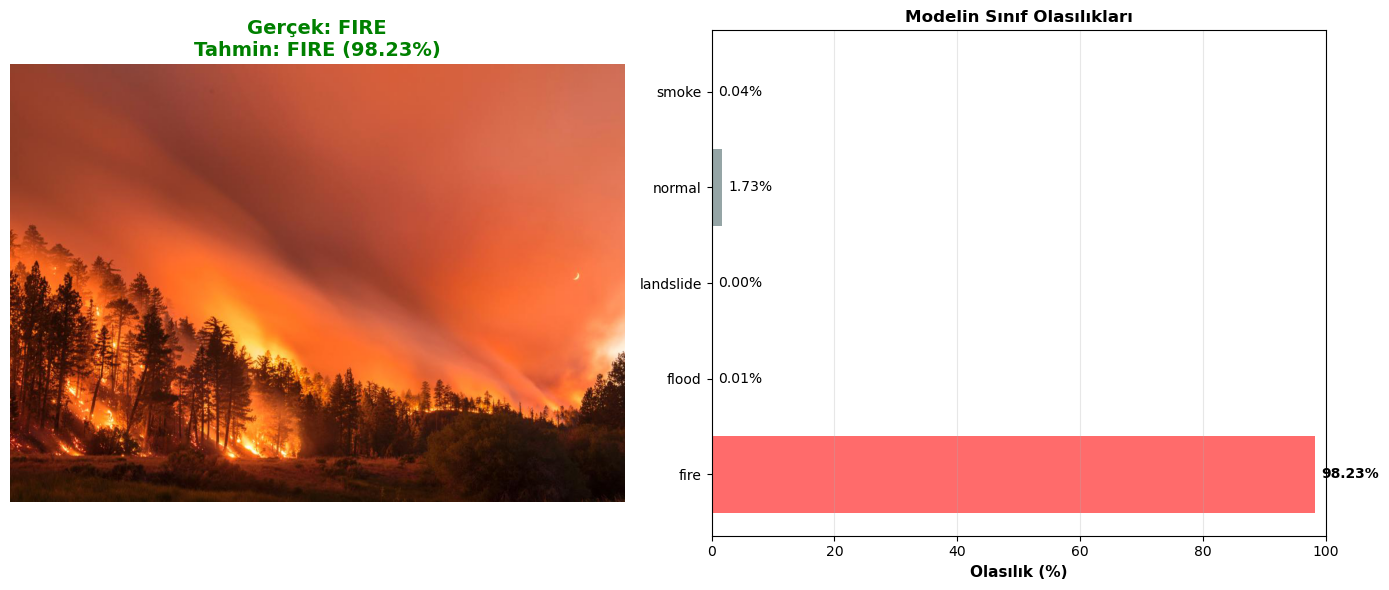

In [25]:
import random
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F

# ---------------------------------------------------------
# FONKSİYON TANIMI
# ---------------------------------------------------------
def predict_image(model, image_path, class_names, device, transform=None):
    """
    Tek bir görüntü için tahmin yap ve görselleştir
    """
    # Modeli değerlendirme moduna al
    model.eval()
    
    # Transform yoksa (None ise) hata vermemesi için kontrol
    if transform is None:
        print("Hata: Transform fonksiyonu belirtilmedi!")
        return None, None, None
    
    # Görüntüyü yükle ve dönüştür
    try:
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)
    except Exception as e:
        print(f"Hata: {image_path} yüklenemedi: {e}")
        return None, None, None
    
    # Tahmin yap
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item() * 100
    
    # Tüm sınıf olasılıklarını sözlük olarak hazırla
    all_probs = {}
    for i, class_name in enumerate(class_names):
        all_probs[class_name] = probabilities[0][i].item() * 100
    
    return predicted_class, confidence_score, all_probs

# ---------------------------------------------------------
# TEK BİR TAHMİN YAPMA VE GÖRSELLEŞTİRME
# ---------------------------------------------------------

print("\n" + "="*60)
print("RASTGELE TEK BİR TAHMİN")
print("="*60)

# Test setinden rastgele tek bir görüntü seç
# Not: test_images ve test_labels listelerinin tanımlı olduğu varsayılmıştır.
if 'test_images' in globals() and len(test_images) > 0:
    # Rastgele bir indeks seç
    random_index = random.randint(0, len(test_images) - 1)
    
    selected_image_path = test_images[random_index]
    true_label_index = test_labels[random_index]
    true_class_name = CLASS_NAMES[true_label_index] # Gerçek sınıfı

    print(f"\nSeçilen Dosya: {os.path.basename(selected_image_path)}")
    print(f"Gerçek Sınıf: {true_class_name.upper()}")
    
    # Tahmin fonksiyonunu çağır
    predicted_class, confidence, all_probs = predict_image(
        model, selected_image_path, CLASS_NAMES, device, val_transform
    )
    
    if predicted_class:
        print(f"Tahmin: {predicted_class.upper()}")
        print(f"Güven: {confidence:.2f}%")
        
        # Konsola Olasılıkları Yazdır
        print(f"\n📈 Olasılık Dağılımı:")
        for cls_name, prob in sorted(all_probs.items(), key=lambda x: x[1], reverse=True):
            marker = " ✅" if cls_name == predicted_class else ""
            print(f"  - {cls_name}: {prob:.2f}%{marker}")
        
        # --- GÖRSELLEŞTİRME KISMI ---
        try:
            original_image = Image.open(selected_image_path).convert('RGB')
            
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            
            # Sol: Görüntü
            axes[0].imshow(original_image)
            axes[0].axis('off')
            
            # Başlık rengi: Doğruysa Yeşil, Yanlışsa Kırmızı
            # Hata alınan yer burasıydı, şimdi blok içinde güvende.
            title_color = 'green' if predicted_class == true_class_name else 'red'
            
            axes[0].set_title(f'Gerçek: {true_class_name.upper()}\nTahmin: {predicted_class.upper()} ({confidence:.2f}%)', 
                            fontsize=14, fontweight='bold', color=title_color)
            
            # Sağ: Olasılık Grafiği
            classes = list(all_probs.keys())
            probs = [all_probs[cls] for cls in classes]
            
            # Renkler: Tahmin edilen kırmızımsı, diğerleri gri
            colors = ['#ff6b6b' if cls == predicted_class else '#95a5a6' for cls in classes]
            
            bars = axes[1].barh(classes, probs, color=colors)
            axes[1].set_xlabel('Olasılık (%)', fontsize=11, fontweight='bold')
            axes[1].set_title('Modelin Sınıf Olasılıkları', fontsize=12, fontweight='bold')
            axes[1].set_xlim(0, 100)
            axes[1].grid(axis='x', alpha=0.3)
            
            # Barların ucuna değerleri yaz
            for i, (bar, prob) in enumerate(zip(bars, probs)):
                width = bar.get_width()
                axes[1].text(width + 1, bar.get_y() + bar.get_height()/2, 
                            f'{prob:.2f}%', 
                            ha='left', va='center', fontsize=10, 
                            fontweight='bold' if classes[i] == predicted_class else 'normal')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"⚠️ Görselleştirme hatası: {e}")

else:
    print("Hata: 'test_images' listesi bulunamadı veya boş! Lütfen veri setini yüklediğiniz hücreleri çalıştırın.")

print(f"\n{'='*60}")